In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.binary_models as binary_models
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_binary_dataset as make_binary_dataset
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import plotting.plots as plots

### Define paths for the model and data of interest

In [2]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/att_priors/data/interim/ENCODE/profile/OLD/SPI1"

peaks_bed = os.path.join(base_path, "SPI1_ENCSR000BGW_K562_all_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2))
    for e_1, e_2 in [
        ("SPI1_ENCSR000BGQ_GM12878_neg.bw",
         "SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1_ENCSR000BGW_K562_neg.bw",
         "SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1_ENCSR000BIJ_GM12891_neg.bw",
         "SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1_ENCSR000BUW_HL-60_neg.bw",
         "SPI1_ENCSR000BUW_HL-60_pos.bw"),

        ("control_ENCSR000BGH_GM12878_neg.bw",
         "control_ENCSR000BGH_GM12878_pos.bw"),
        ("control_ENCSR000BGG_K562_neg.bw",
         "control_ENCSR000BGG_K562_pos.bw"),
        ("control_ENCSR000BIH_GM12891_neg.bw",
         "control_ENCSR000BIH_GM12891_pos.bw"),
        ("control_ENCSR000BVU_HL-60_neg.bw",
         "control_ENCSR000BVU_HL-60_pos.bw")
    ]
]
num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
model_path = "/users/amtseng/att_priors/models/trained_profile_models/SPI1_TEST/20/model_ckpt_epoch_2.pt"

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [3]:
# Define some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000

In [4]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=1)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)

In [5]:
# Maps single coordinate to input sequence and profiles for the network
def coord_to_network_inputs(chrom, start, end):
    input_seq = coords_to_seq([(chrom, start, end)])
    profs = coords_to_profs([(chrom, start, end)])
    return input_seq, profs

In [6]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting outputs

In [7]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

In [131]:
def input_gradients(model, input_seq, profile_length, logit_pred_profs, log_pred_counts):
    """
    Given the prediction tensors for a batch of input sequences, computes
    the gradient with respect to the input sequence. `model` is the trained
    model. `input_seq` is the input sequence tensor, and `profile_length` is
    the actual length of the output profile.
    """
    # TODO: perhaps we should average across each profile, then take the sum?
    model.zero_grad() # Clear gradients
    plus_profs = logit_pred_profs[:, :, 1, :]
    plus_profs.backward(
        model_util.place_tensor(torch.ones(plus_profs.size())),
        retain_graph=True
    )  # Sum gradient across profiles
    
    input_grads = input_seq.grad
    
    # Multiply by input sequence to get rid of the non-actual bases
    input_grads = input_grads * input_seq
    
    left = int((input_seq.shape[2] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, :, left:right]
    return torch.transpose(input_grads, 1, 2)  # Turn input into B x L x 4

In [127]:
def model_grads(model, chrom, start, end, profile_length):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values, and the input
    gradients with respect to the profiles and the counts.
    The returned profiles are in terms of raw counts, and the returned counts are
    also raw. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coord_to_network_inputs(chrom, start, end)
    
    input_seq = model_util.place_tensor(torch.tensor(input_seq)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Make channels come first in input
    input_seq = torch.transpose(input_seq, 1, 2)
    
    # Run input through model
    torch.set_grad_enabled(True)  # We actually do need grad here
    input_seq.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seq, cont_profs)
    
    # Compute input gradients
    input_grads = input_gradients(model, input_seq, profile_length, logit_pred_profs, log_pred_counts)
    
    # Convert logit profile predictions to probabilities
    sig_pred_profs = torch.nn.Sigmoid()(logit_pred_profs)
    sig_sums = torch.sum(sig_pred_profs, dim=-1).unsqueeze(-1)
    pred_prof_probs = torch.div(sig_pred_profs, sig_sums)
    
    # Convert log counts to counts
    pred_counts = torch.exp(log_pred_counts)
    
    # Convert profile probabilities to profile counts
    pred_profs = torch.mul(pred_prof_probs, pred_counts.unsqueeze(-1).repeat(1, 1, 1, pred_prof_probs.size(-1)))
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=3)
    
    return pred_profs.detach().cpu().numpy()[0], \
           pred_counts.detach().cpu().numpy()[0], \
           true_profs.cpu().numpy()[0], \
           true_counts.cpu().numpy()[0], \
           input_grads.detach().cpu().numpy()[0]

In [90]:
# Sample a set of positives and negatives randomly
np.random.seed(20191022)
pos_coords = pos_coords_table.sample(1000).values
neg_coords = neg_coord_sampler.sample_intervals(1000)
coords = np.concatenate([pos_coords, neg_coords], axis=0)

### Compute and plot gradients

In [132]:
pos_input_grads, neg_input_grads = [], []
for pos_coord in tqdm.tqdm_notebook(pos_coords):  
    output = model_grads(model, *pos_coord, profile_length)
    pred_profs, pred_counts, true_profs, true_counts, input_grads = output
    pos_input_grads.append(input_grads)
for neg_coord in tqdm.tqdm_notebook(neg_coords):  
    output = model_grads(model, *neg_coord, profile_length)
    pred_profs, pred_counts, true_profs, true_counts, input_grads = output
    neg_input_grads.append(input_grads)

In [12]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [83]:
def plot_grad_and_fft(grads, include_dc=False):
    assert len(grads.shape) == 2
    
    relu_grads = grads.copy()  # Make a copy
    relu_grads[relu_grads < 0] = 0  # Pass through ReLU
    
    sum_abs_grads = np.sum(np.abs(grads), axis=1)
    
    # Take maximum over all 4 channels for each base
    max_relu_grads = np.max(relu_grads, axis=1)
    freqs, mags = dft(max_relu_grads)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, cut-off gradients, and the DFT
    viz_sequence.plot_weights(grads, subticks_frequency=100)
    fig, ax = plt.subplots(3, 1, figsize=(20, 8))
    ax[0].plot(np.arange(len(max_relu_grads)), max_relu_grads, color="blue")
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("max(ReLU(grad))")
    ax[0].margins(0)
    ax[1].plot(np.arange(len(sum_abs_grads)), sum_abs_grads, color="blue")
    ax[1].set_xlabel("X")
    ax[1].set_ylabel("sum(|grad|)")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    ax[2].margins(0)
    plt.tight_layout()
    plt.show(block=False)
    
    # return freqs, mags

['chr6' 150184612 150185612]
[[ 0.        -0.         0.        -0.7159699]
 [ 0.        -0.         0.        -6.1841846]
 [ 0.        -0.         0.        -7.370913 ]
 ...
 [ 0.        22.871496  -0.        -0.       ]
 [-0.         0.         0.        -3.6575828]
 [ 0.        18.453981   0.        -0.       ]]


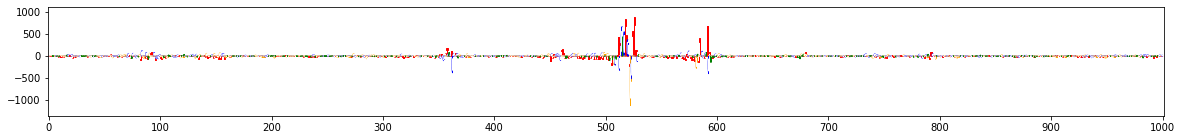

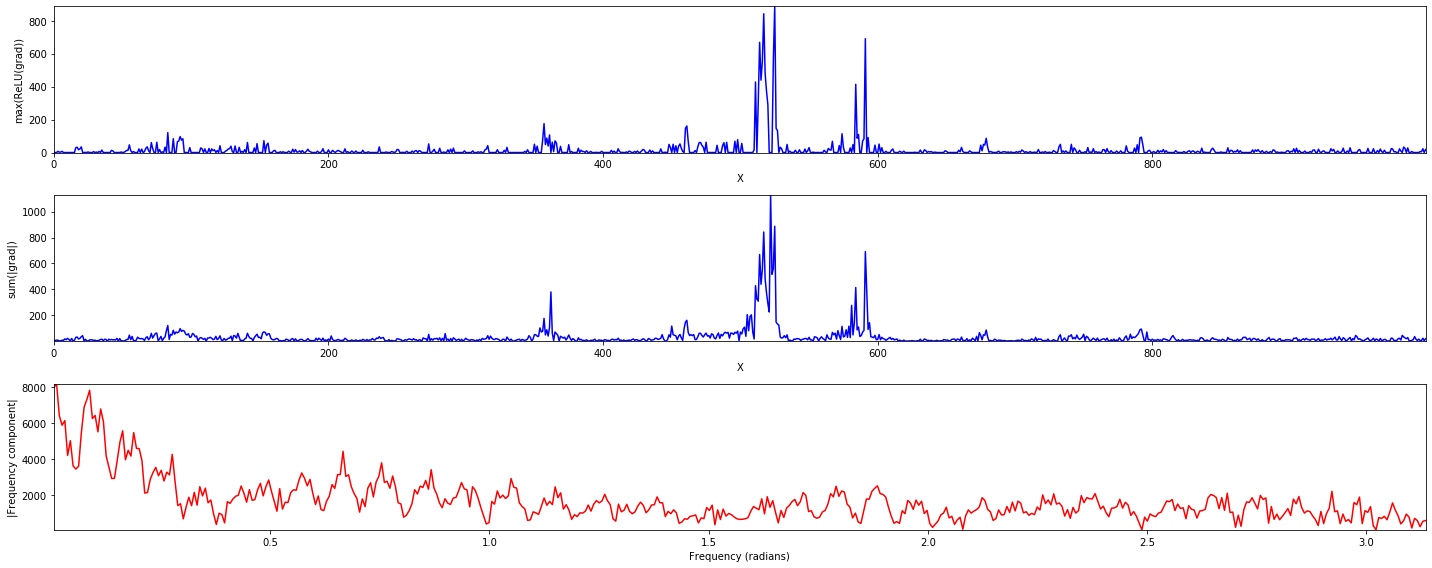

In [133]:
print(pos_coords[1])
plot_grad_and_fft(pos_input_grads[1])

['chr2' 64263959 64264959]


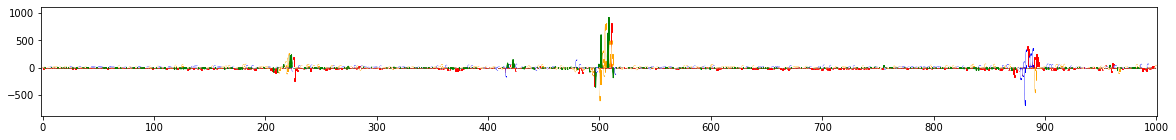

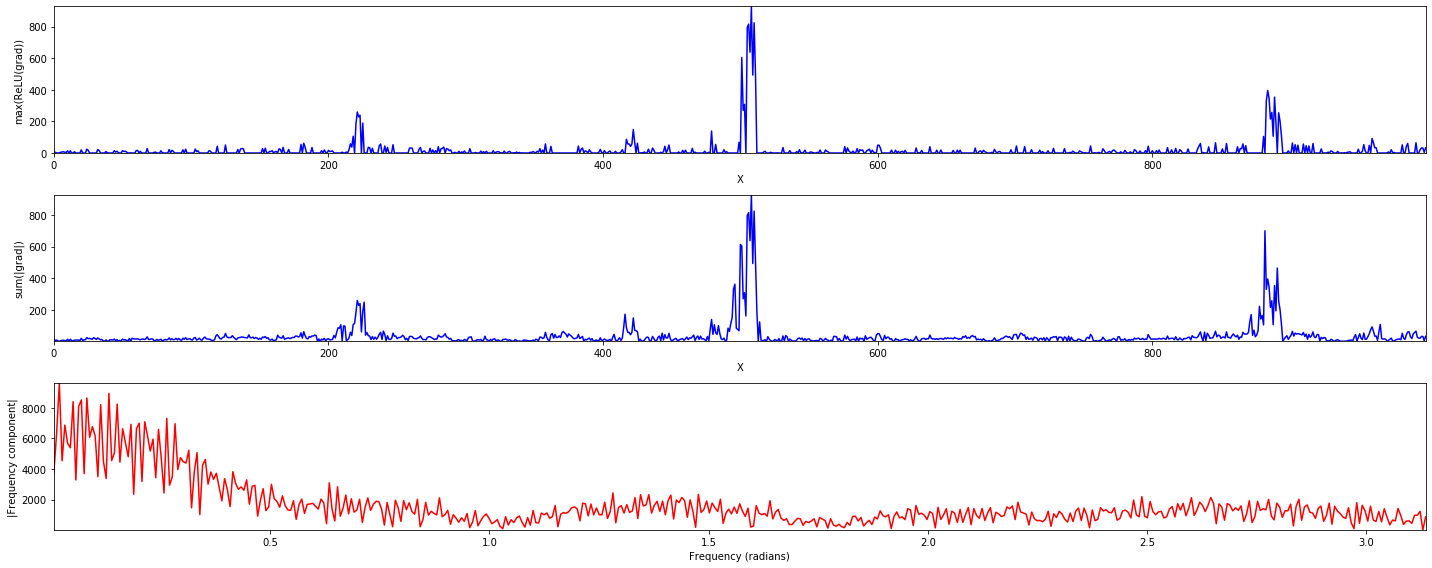

In [134]:
print(pos_coords[5])
plot_grad_and_fft(pos_input_grads[5])

['chr2' 180478319 180479665]


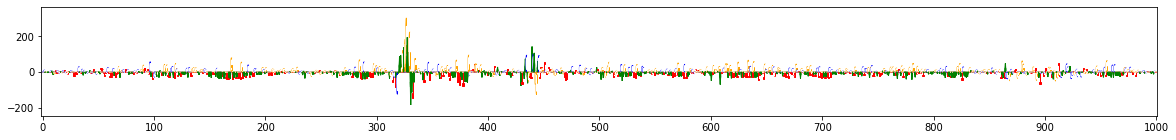

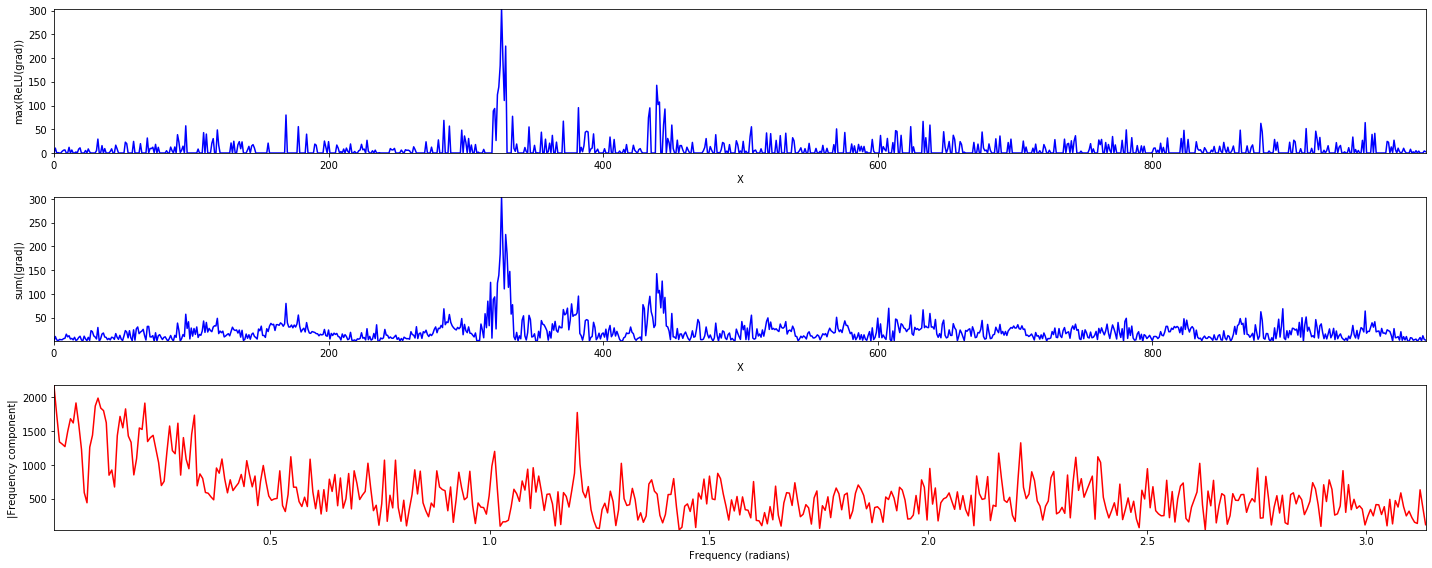

In [135]:
print(neg_coords[5])
plot_grad_and_fft(neg_input_grads[5])

['chr3' 116762407 116763753]


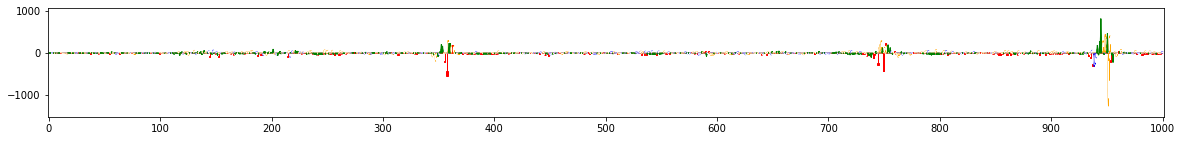

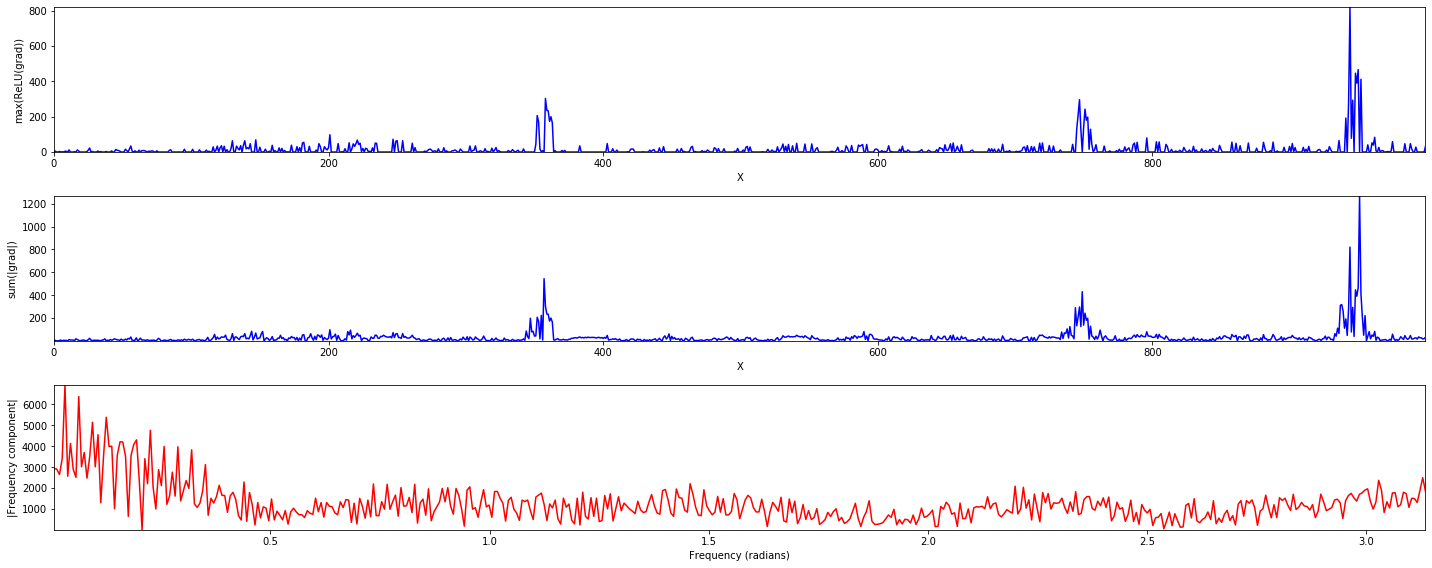

In [136]:
print(neg_coords[50])
plot_grad_and_fft(neg_input_grads[50])

['chr9' 60457357 60458703]


/users/amtseng/att_priors/src/plot/viz_sequence.py:125: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)


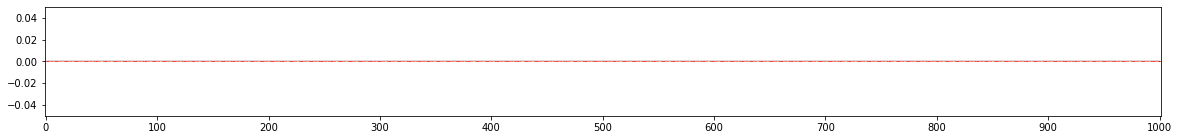

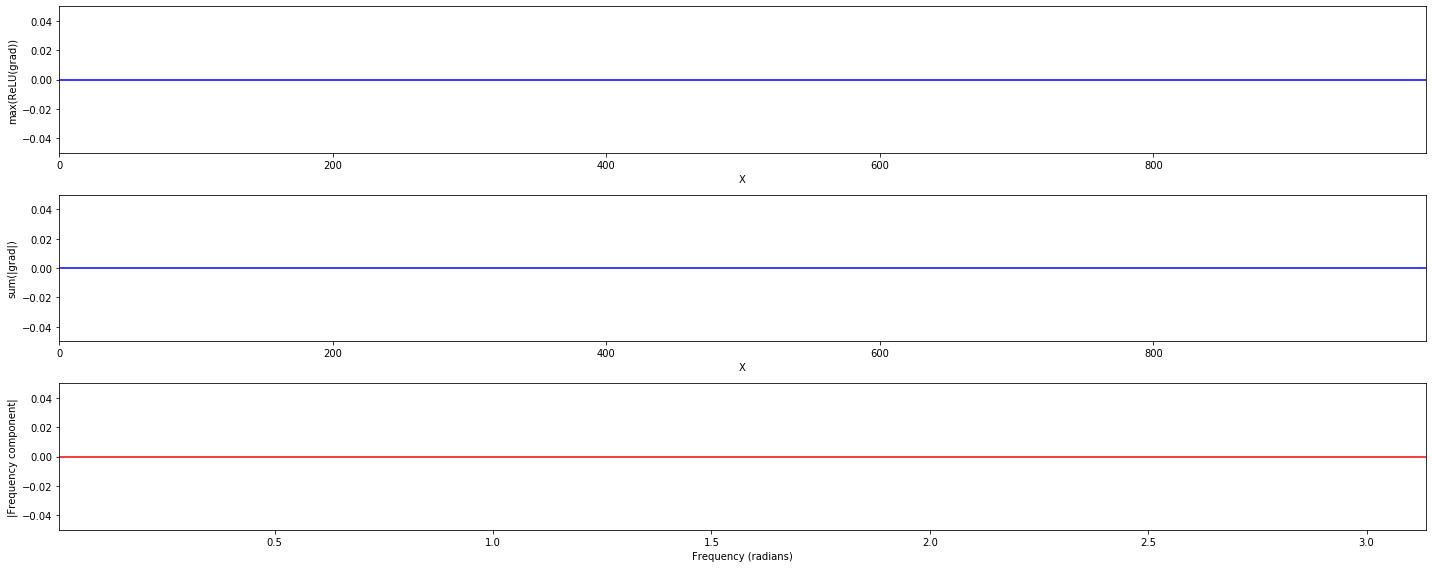

In [137]:
print(neg_coords[10])
plot_grad_and_fft(neg_input_grads[10])

In [158]:
def grad_score_neg(grad):
    """
    Computes score for a negative example given the gradients.
    """
    assert len(grad.shape) == 2
    relu_grad = grad.copy()  # Make a copy
    relu_grad[relu_grad < 0] = 0  # Pass through ReLU
    
    # The entire signal should be as close to 0 as possible
    return np.sum(relu_grad)

In [163]:
def grad_score_pos(grad, freq_limit=0.5):
    """
    Computes score for a positive example given the gradients.
    """
    assert len(grad.shape) == 2
    grad = grad.copy()  # Make a copy
    grad[grad < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grad = np.max(grad, axis=1)
    freqs, mags = dft(grad)
    
    freqs, mags = freqs[1:], mags[1:]  # Exclude DC
    
    if np.sum(mags):
        mags = mags / np.sum(mags)  # Normalize
    
    # Sum up the area under the low-frequency region
    return np.sum(mags[freqs <= freq_limit])

In [154]:
def plot_score_distributions(pos_grads, neg_grads):
    neg_losses_on_pos = np.array([grad_score_neg(grad) for grad in pos_grads])
    neg_losses_on_neg = np.array([grad_score_neg(grad) for grad in neg_grads])
    pos_losses_on_pos = np.array([grad_score_pos(grad) for grad in pos_grads])
    pos_losses_on_neg = np.array([grad_score_pos(grad) for grad in neg_grads])
    
    # return neg_losses_on_pos, neg_losses_on_neg, pos_losses_on_pos, pos_losses_on_neg
    
    plots.plot_multi_histogram(
        [neg_losses_on_pos, neg_losses_on_neg], ["Positives", "Negatives"], 400, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Rectified gradient sum", xlabel="Score"
    
    )
    plots.plot_multi_histogram(
        [pos_losses_on_pos, pos_losses_on_neg], ["Positives", "Negatives"], 0.01, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Sum of low frequency Fourier coefficients on gradients", xlabel="Score"
    )
    

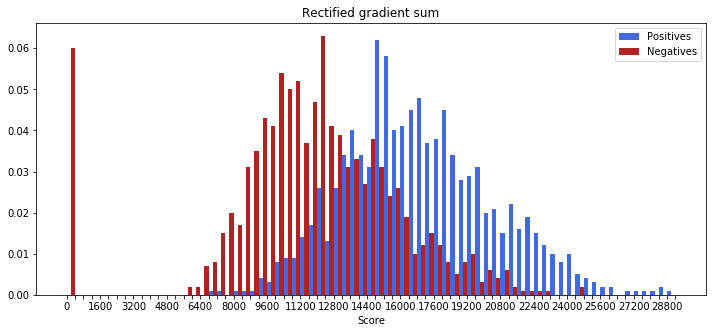

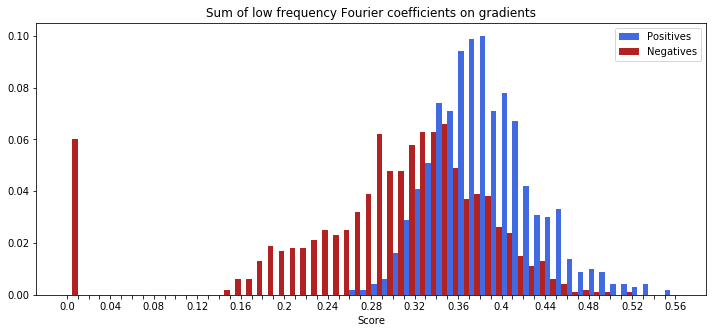

In [164]:
plot_score_distributions(pos_input_grads, neg_input_grads)